In [25]:
import numpy as np
import pandas as pd

In [102]:
dataset = pd.read_csv('/users/he145100/OneDrive - WA Health/Test Data/vw_emergency_episode_50k_departure_status.csv', dtype={
                                                                               'standard_australian_classification_of_countries_2011_for_country_of_birth':'str',
                                                                                'short_stay_unit_departure_status':'str'})

In [103]:
list(dataset.columns)

['establishment_code',
 'sex',
 'ethnicity',
 'marital_status',
 'interpreter_required',
 'employment_status',
 'occupation',
 'triage_category',
 'departure_status',
 'destination_on_departure',
 'visit_type',
 'mode_of_arrival',
 'referral_source',
 'primary_diagnosis',
 'presenting_complaint',
 'major_diagnostic_category',
 'human_intent_of_injury',
 'external_cause_of_injury',
 'STATE',
 'referred_to_on_departure',
 'additional_diagnosis',
 'short_stay_unit_destination_on_departure',
 'short_stay_unit_departure_status',
 'senior_doctor_type',
 'place_where_injury_occurred',
 'type_of_activity_when_injury_occurred',
 'ambulance_number',
 'statistical_area_2_2016',
 'payment_classification',
 'aboriginality',
 'primary_diagnosis_ICD10AM_chapter',
 'principal_diagnosis_system_code_EDIS',
 'additional_diagnosis_system_code_EDIS',
 'standard_australian_classification_of_countries_2011_for_country_of_birth',
 'australian_postcode',
 'metropolitan_hospital_flag',
 'rural_hospital_flag',
 

In [104]:
data[data.select_dtypes(np.float64).columns] = data.select_dtypes(np.float64).astype(np.float32)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47499 entries, 0 to 47498
Data columns (total 76 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   establishment_code                                                                         47499 non-null  int64  
 1   sex                                                                                        47499 non-null  int64  
 2   ethnicity                                                                                  47499 non-null  int64  
 3   marital_status                                                                             47499 non-null  int64  
 4   interpreter_required                                                                       47499 non-null  int64  
 5   employment_status                             

In [105]:
dataset.shape

(49999, 76)

In [106]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (47499, 76)
Unseen Data For Predictions: (2500, 76)


In [107]:
from pycaret.classification import *

In [108]:
#Ordinal Encoding
#When the categorical features in the dataset contain variables with intrinsic natural order such as Low, Medium, and High, 
#these must be encoded differently than nominal variables (where there is no intrinsic order for e.g. Male or Female). 
#This can be achieved using  the ordinal_features parameter in the setup function that accepts a dictionary with feature 
#names and the levels in the increasing order from lowest to highest.

#triage rating needs to setup as ordinal 
#ordinal_features = {'triage_category' : ['7','5','4','3','2','1']},
admission_test_1 = setup(data = data, target = 'departure_status',
                         ignore_features = ['reattendance_within_48_hours_for_the_same_condition_denominator', 
                                          'short_stay_unit_destination_on_departure',
                                          'short_stay_unit_departure_status',
                                          'destination_on_departure',
                                          'referred_to_on_departure'
                                          ],
                         normalize = True,
                         ordinal_features = {'triage_category' : ['7','5','4','3','2','1']},
                         high_cardinality_features = ['presenting_complaint','australian_postcode','primary_diagnosis','primary_diagnosis_ICD10AM_chapter',
                                                      'principal_diagnosis_system_code_EDIS'], 
                         bin_numeric_features = ['age'],
                         session_id=123) 

,Description,Value
0,session_id,123
1,Target,departure_status
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(47499, 76)"
5,Missing Values,True
6,Numeric Features,7
7,Categorical Features,63
8,Ordinal Features,True
9,High Cardinality Features,True


In [77]:
best_model = compare_models(exclude = ['gbc', 'svm', 'lda','qda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9749,0.2985,0.7010,0.9698,0.9703,0.9410,0.9414,17.1880
et,Extra Trees Classifier,0.9653,0.2977,0.5486,0.9586,0.9585,0.9174,0.9185,8.6680
rf,Random Forest Classifier,0.9648,0.2978,0.5400,0.9575,0.9574,0.9162,0.9175,5.1530
dt,Decision Tree Classifier,0.9647,0.2918,0.6857,0.9640,0.9643,0.9181,0.9182,1.8060
ridge,Ridge Classifier,0.9641,0.0000,0.5255,0.9563,0.9502,0.9147,0.9165,2.8490
ada,Ada Boost Classifier,0.9166,0.2746,0.4201,0.8781,0.8859,0.7969,0.8076,12.7640
lightgbm,Light Gradient Boosting Machine,0.7954,0.1964,0.3307,0.8032,0.7884,0.4901,0.4961,1.1840
knn,K Neighbors Classifier,0.7619,0.2328,0.3055,0.7329,0.7406,0.3806,0.3879,10.6410
lr,Logistic Regression,0.7268,0.1392,0.1375,0.5282,0.6118,0.0000,0.0000,5.6970
dummy,Dummy Classifier,0.7268,0.1500,0.1375,0.5282,0.6118,0.0000,0.0000,0.1370


In [78]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9744,0.0000,0.7106,0.9731,0.9705,0.9399,0.9402
1,0.9768,0.0000,0.7054,0.9702,0.9718,0.9456,0.9461
2,0.9777,0.0000,0.7144,0.9774,0.9732,0.9478,0.9482
3,0.9726,0.0000,0.6973,0.9674,0.9678,0.9358,0.9363
4,0.9759,0.0000,0.7816,0.9684,0.9714,0.9436,0.9439
5,0.9711,0.0000,0.6992,0.9652,0.9665,0.9325,0.9328
6,0.9771,0.9963,0.6924,0.9733,0.9731,0.9464,0.9468
7,0.9744,0.9940,0.6762,0.9668,0.9695,0.9400,0.9404
8,0.9735,0.9949,0.5597,0.9685,0.9692,0.9379,0.9383


In [50]:
print(catboost)

In [79]:
tuned_catboost = tune_model(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9732,0.0000,0.6240,0.9654,0.9683,0.9369,0.9374
1,0.9714,0.0000,0.6076,0.9635,0.9651,0.9325,0.9332
2,0.9738,0.0000,0.6248,0.9656,0.9685,0.9384,0.9389
3,0.9705,0.0000,0.6100,0.9614,0.9642,0.9305,0.9312
4,0.9720,0.0000,0.6319,0.9637,0.9675,0.9343,0.9346
5,0.9699,0.0000,0.6127,0.9604,0.9640,0.9294,0.9298
6,0.9768,0.9951,0.5701,0.9754,0.9729,0.9456,0.9459
7,0.9714,0.9930,0.5414,0.9626,0.9659,0.9327,0.9332
8,0.9699,0.9916,0.5341,0.9609,0.9641,0.9290,0.9296


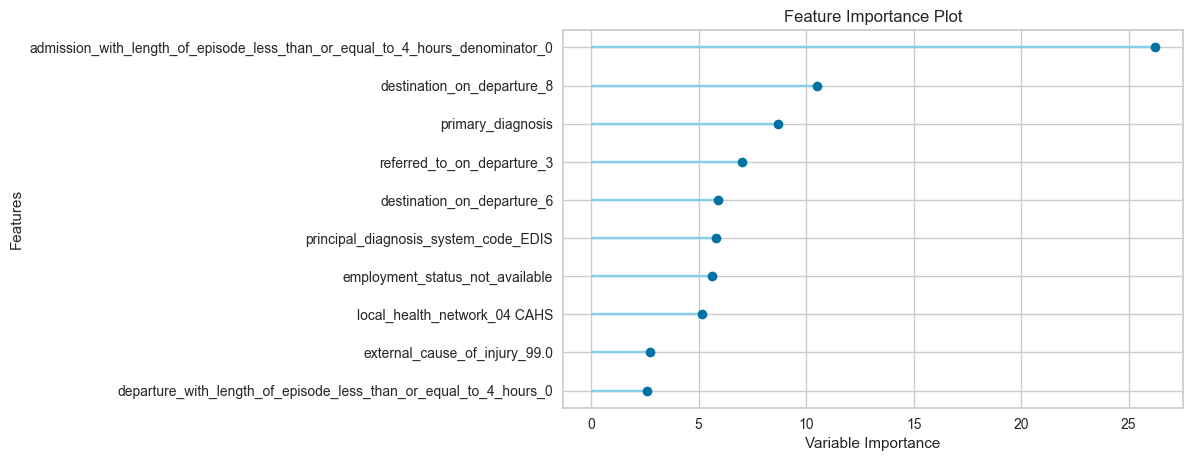

In [68]:
plot_model(tuned_catboost, plot='feature')

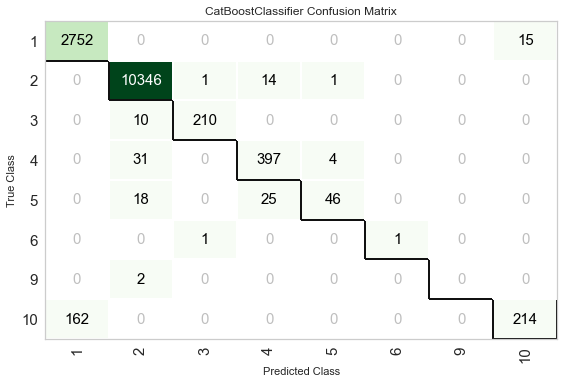

In [69]:
plot_model(tuned_catboost, plot = 'confusion_matrix')
#https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
#True Positive:
#Interpretation: You predicted positive and it’s true.
#You predicted that a woman is pregnant and she actually is.
#True Negative:
#Interpretation: You predicted negative and it’s true.
#You predicted that a man is not pregnant and he actually is not.
#False Positive: (Type 1 Error)
#Interpretation: You predicted positive and it’s false.
#You predicted that a man is pregnant but he actually is not.
#False Negative: (Type 2 Error)
#Interpretation: You predicted negative and it’s false.
#You predicted that a woman is not pregnant but she actually is.

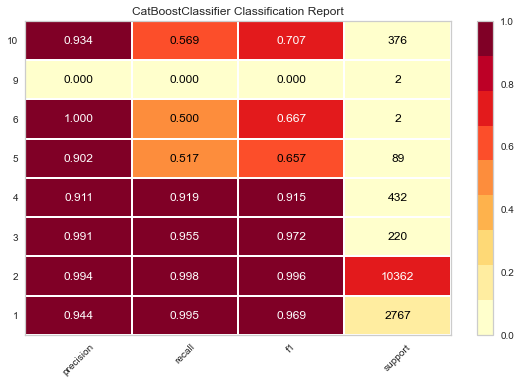

In [70]:
plot_model(tuned_catboost, plot = 'class_report')

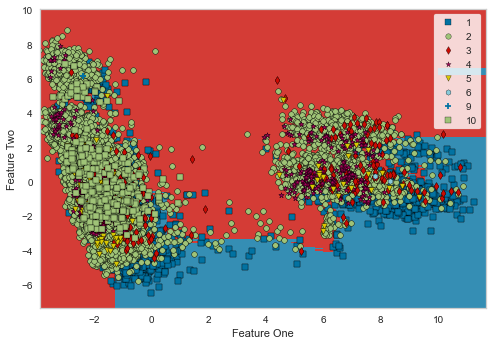

In [71]:
plot_model(tuned_catboost, plot='boundary')

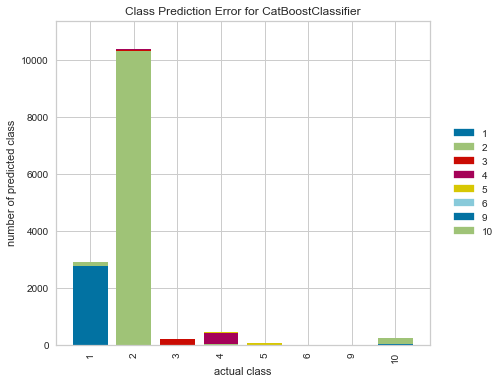

In [72]:
plot_model(tuned_catboost, plot = 'error')

In [73]:
evaluate_model(tuned_catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [74]:
predict_model(tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9801,0.9986,0.6816,0.9796,0.9782,0.9534,0.9537


IndexError: index 10 is out of bounds for axis 0 with size 8

In [60]:
final_catboost = finalize_model(tuned_catboost)

In [61]:
#Final Catboost parameters for deployment
print(final_catboost)

In [62]:
unseen_predictions = predict_model(final_catboost, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9964,0,0.9458,0.9963,0.9962,0.9918,0.9918


IndexError: index 10 is out of bounds for axis 0 with size 8

In [63]:
unseen_predictions[["departure_status","Label"]].head(50)

NameError: name 'unseen_predictions' is not defined

In [77]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['admission'], unseen_predictions['Label'], metric = 'Accuracy')

0.956